# Fire Duration and Emitted FRP Analysis

## Overview
This script analyzes the distribution of fire durations from their start to peak and explores the correlation between fire duration and emitted Fire Radiative Power (FRP). It includes data processing, visualization, and regression modeling to derive insights from fire event datasets.

---

## **1. Distribution of Fire Duration**
This section calculates and plots the distribution of fire durations.

### **Steps:**
- Compute the duration from fire start to peak and convert it to hours.
- Configure and plot a histogram showing the relative frequency distribution.
- Overlay statistical measures such as mean and median.

---

## **2. Regression Model for Fire Duration and Emitted FRP**
This section examines the relationship between fire duration and the total FRP emitted.

### **Steps:**
1. Extract relevant data from the dataset:
   - Latitude, Longitude, and FRP values.
2. Identify fire peaks using peak detection techniques.
3. Compute fire durations and corresponding FRP emissions.
4. Apply logarithmic transformation to both variables.
5. Fit a linear regression model:
   - **Function**: \( y = ax + b \)
   - **Parameters**: Slope (\( a \)) and Intercept (\( b \))
6. Compute statistical metrics:
   - Pearson correlation coefficient (\( r \)).
   - R-squared (\( R^2 \)) for model goodness-of-fit.
7. Generate confidence and prediction bands.

---

## **3. Output**
- Five visualizations:
  - Histogram of fire durations.
  - Histogram of duration from the start to the peak of FRP during fire events
  - Histogram of duration from peak to end
  - Scatter plot with regression model and confidence bands.
  - Example plot of the FRP measured over the time for one grid point

In [ ]:
# Install required Python packages:
# - `uncertainties`: Library for error propagation in calculations.
# - `timezones`: Library for handling and converting time zones.
%pip install uncertainties timezones

In [ ]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import math as mt
from scipy import stats
from scipy.optimize import curve_fit
import uncertainties.unumpy as unp
import uncertainties as unc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
from scipy.signal import chirp, find_peaks, peak_widths,find_peaks_cwt
from timezonefinder import TimezoneFinder
from timezones import tz_utils
import matplotlib.ticker as ticker

In [ ]:
# Define the directory containing processed emission data
datadir = '/Path'

# Define the year for processing (adjustable for different analyses)
Year = 2020

# Example filename format:
# goes_data_emission_rate_amazon_definitive_box_YYYY_150_350.csv
# - YYYY: Year of the data
# - 150_350: Specific time or location identifier

# Retrieve all matching CSV files for the specified year
data = sorted(glob.glob(datadir + '/*goes_data_emission_rate_amazon_definitive_box_' + str(Year) + '_150_350.csv'))
#print(data)  # Uncomment to check the retrieved file list

# Available columns in the dataset:
# 'sat', 'year', 'julian', 'hhmm', 'code', 'central_lat', 'central_lon', 'FRP(MW)', 'N_FRP',
# 'FRE(MJ)', 'RE(kg/s)', 'ME(kg)', 'CO_2(kg)', 'sigma_CO_2(kg)', 'CO(kg)', 'sigma_CO(kg)',
# 'CH4(kg)', 'sigma_CH4(kg)', 'mean_FRP(MW)', 'mean_temp(K)', 'sum_area(m2)', 'mean_area(m2)'

# Select only the relevant columns for analysis
selected_columns = ['central_lat', 'central_lon', 'FRP(MW)', 'hhmm', 'code']

# Read the first available CSV file, extracting only the selected columns
emission_data = pd.read_csv(data[0], usecols=selected_columns)

In [ ]:
# Define the bounding box coordinates for a region of interest
# Box 1: For the first example, the bounding box covers a region in the Amazon area
minlon, maxlon, minlat, maxlat = -72, -48, -11, -3  # Example box 1

# Box 2: For the second example, the bounding box covers a different region
#minlon, maxlon, minlat, maxlat = -58, -56, -18, -16 # Example box 2

# Box 3: For the second example, the bounding box covers a different region, smaller, in the Amazon
#minlon, maxlon, minlat, maxlat = -57, -54, -9, -6  # Amazon small box

In [ ]:
# Generate evenly spaced grid center points for longitude and latitude
# - The grid spacing is 0.5 degrees (2 points per degree)
centers_lon = np.linspace(minlon + 0.25, maxlon - 0.25, num=int((maxlon - minlon) * 2))
centers_lat = np.linspace(minlat + 0.25, maxlat - 0.25, num=int((maxlat - minlat) * 2))

# Create a matrix of latitude and longitude grid points
for i in range(len(centers_lat)):
    if i == 0:
        # First row: create latitude column and combine with longitude values
        aux = np.repeat(centers_lat[i], len(centers_lon))
        lat_lon_feer = np.column_stack((aux, centers_lon))
    else:
        # Create new row of latitude values and stack it to the existing matrix
        aux = np.repeat(centers_lat[i], len(centers_lon))
        aux2 = np.column_stack((aux, centers_lon))
        lat_lon_feer = np.vstack((lat_lon_feer, aux2))

# Final matrix containing all grid points (latitude, longitude)
matrix = lat_lon_feer

In [ ]:
# The FRP (Fire Radiative Power) data is collected, and 'find_peaks' is used to identify peak values.
# It retrieves the fire duration, start, and end times of detected fire events.

# List the data file header
header = list(emission_data)

# Extract latitude values from the dataset
pos1 = header.index('central_lat')
column1 = emission_data.iloc[:, pos1]
lat = np.array(column1.dropna(), dtype=pd.Series)  # Convert to NumPy array, removing NaN values

# Extract longitude values from the dataset
pos2 = header.index('central_lon')
column2 = emission_data.iloc[:, pos2]
lon = np.array(column2.dropna(), dtype=pd.Series)

# Extract FRP values (Fire Radiative Power in MW) from the dataset
pos3 = header.index('FRP(MW)')
column3 = emission_data.iloc[:, pos3]
FRP = np.array(column3.dropna(), dtype=pd.Series)

# Select data points that match the first grid point in the defined region and have valid FRP values
index = np.where((lat == matrix[0, 0]) & (lon == matrix[0, 1]) & (FRP >= 0))
FRP_aux = FRP[index]  # Extract FRP values for the selected indices

# Use 'find_peaks' to identify fire events in the FRP data
peaks, _ = find_peaks(FRP_aux, height=75, distance=50, prominence=750)

# Measure peak widths (fire durations), start, and end times
results_width = peak_widths(FRP_aux, peaks, rel_height=0.95)
fire_duration = (results_width[0] * 10) / 60  # Convert time from 10-minute intervals to hours
peak_start = np.int_(np.floor(results_width[2][:]))  # Start times of peaks
peak_end = np.int_(np.ceil(results_width[3][:]))  # End times of peaks

# Loop through the entire grid of the area of interest
for i in range(1, len(matrix)):
    # Select data points corresponding to the current grid point
    index = np.where((lat == matrix[i, 0]) & (lon == matrix[i, 1]) & (FRP >= 0))
    FRP_aux = FRP[index]

    # Detect fire peaks for the current grid point
    peaks_aux, _ = find_peaks(FRP_aux, height=75, distance=50, prominence=750)
    results_width_aux = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
    fire_duration_aux = (results_width_aux[0] * 10) / 60  # Convert to hours
    peak_start_aux = np.int_(np.floor(results_width_aux[2][:]))  # Start times
    peak_end_aux = np.int_(np.ceil(results_width_aux[3][:]))  # End times

    # Append results to existing lists
    fire_duration = np.append(fire_duration, fire_duration_aux)
    peaks = np.append(peaks, peaks_aux)
    peak_start = np.append(peak_start, peak_start_aux)
    peak_end = np.append(peak_end, peak_end_aux)

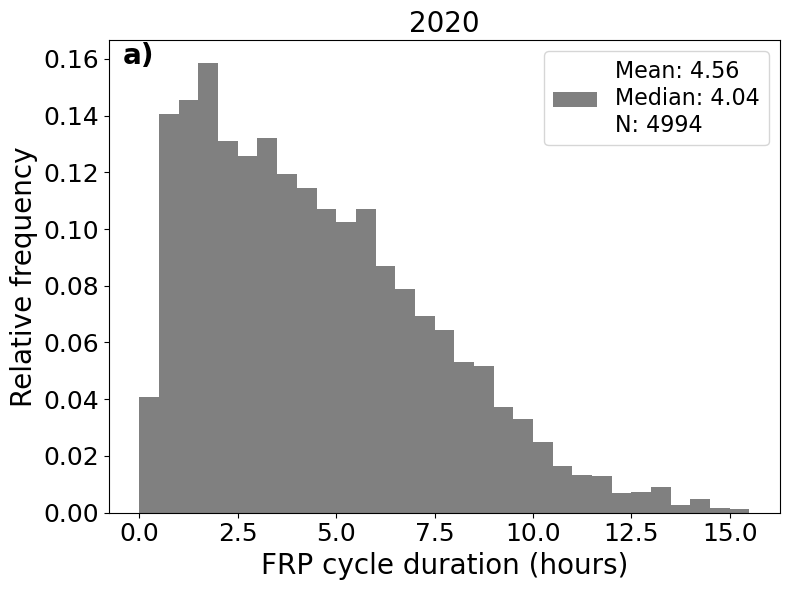

In [7]:
#Plot the distribuition of fire durations

#Configure the plot
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('FRP cycle duration (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'a)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images

#Define plot limits
limits = [0, 16]
division_points = np.arange(0, 16, 0.5) #Configure the bins

#Plot histogram
plt.hist(fire_duration, bins=division_points, range=limits,density=True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(fire_duration),np.median(fire_duration),len(fire_duration))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()
plt.show()
#And save
#pyplot.savefig('filename.png',dpi=300)

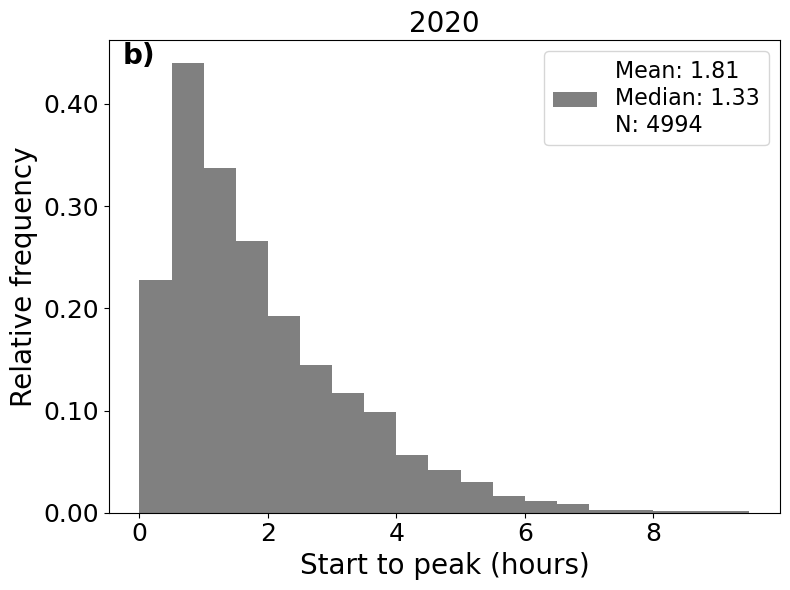

In [8]:
#Plot the distribuition of durations from the start to the peak of fires
#Configure the plot
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('Start to peak (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'b)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images

#Calculate the duration from the start to the peak and convert to hours
diff_start_to_peak =  np.subtract(peaks,peak_start)
diff_start_to_peak_minutes =  diff_start_to_peak*10
diff_start_to_peak_hours = diff_start_to_peak_minutes/60

#Define plot limits
limits = [0, 10]
division_points = np.arange(0, 10, 0.5)#Configure the bins

#Plot histogram
plt.hist(diff_start_to_peak_hours, bins=division_points, range=limits,density = True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(diff_start_to_peak_hours),np.median(diff_start_to_peak_hours),len(diff_start_to_peak_hours))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()
plt.show()
#And save
#pyplot.savefig('filename.png',dpi=300)

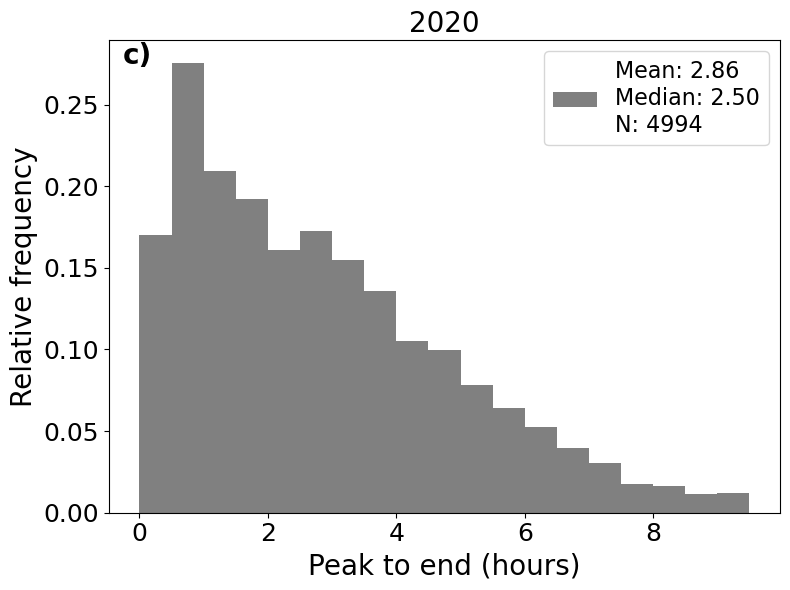

In [9]:
#Plot the distribuition of durations from the peak to the end of fires
#Configure the plot
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('Peak to end (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'c)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images


#Calculate the duration from the peak to the end and convert to hours
diff_end_to_peak =  np.subtract(peak_end,peaks)
diff_end_to_peak_minutes =  diff_end_to_peak*10
diff_end_to_peak_hours = diff_end_to_peak_minutes/60

#Define plot limits
limits = [0, 10]
division_points = np.arange(0, 10, 0.5)#Configure the bins

#Plot histogram
plt.hist(diff_end_to_peak_hours, bins=division_points, range=limits,density=True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(diff_end_to_peak_hours),np.median(diff_end_to_peak_hours),len(diff_end_to_peak_hours))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()
plt.show()
#And save
#plt.savefig('filename.png',dpi=300)

In [ ]:
# Define a linear function y = ax + b
def f(x, a, b):
    return a * x + b

# Function to compute prediction bands for a given regression model
def predband(x, xd, yd, p, func, conf=0.95):
    """
    Computes the upper and lower prediction bands for a regression model.
    
    Parameters:
    x    : Array of x values for which predictions are needed
    xd   : Observed x data
    yd   : Observed y data
    p    : Estimated parameters of the model
    func : Regression function
    conf : Confidence level (default is 0.95)
    
    Returns:
    lpb, upb : Lower and upper prediction bands
    """
    alpha = 1.0 - conf  # Significance level
    N = xd.size  # Sample size
    var_n = len(p)  # Number of model parameters
    
    # Compute Student's t critical value
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    
    # Standard error of the estimate
    se = np.sqrt(1.0 / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
    
    # Compute the prediction interval
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    yp = func(x, *p)  # Predicted values
    dy = q * se * np.sqrt(1.0 + (1.0 / N) + (sx / sxd))  # Margin of error
    
    # Compute upper and lower bounds
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

# Function to analyze the correlation between fire duration and emitted FRP
def fire_duration_x_FRP_emitted(data_fire, filename, matrix):
    """
    Analyzes the relationship between fire duration and Fire Radiative Power (FRP) emitted.
    
    Parameters:
    data_fire : DataFrame containing fire event data
    filename  : Name of the output file for saving plots
    matrix    : Array defining the grid region of interest
    """
    # Extract relevant columns from the dataset
    header = list(data_fire)
    lat = np.array(data_fire.iloc[:, header.index('central_lat')].dropna(), dtype=pd.Series)
    lon = np.array(data_fire.iloc[:, header.index('central_lon')].dropna(), dtype=pd.Series)
    FRP = np.array(data_fire.iloc[:, header.index('FRP(MW)')].dropna(), dtype=pd.Series)
    
    FRP_emitted = []
    fire_duration = []
    
    # Loop through each grid cell in the region of interest
    for i in range(len(matrix)):
        index = np.where((lat == matrix[i, 0]) & (lon == matrix[i, 1]) & (FRP >= 0))
        FRP_aux = FRP[index]
        
        # Identify fire peaks based on FRP values
        peaks_aux, _ = find_peaks(FRP_aux, height=75, distance=50, prominence=750)
        results_width_aux = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
        fire_duration_aux = (results_width_aux[0] * 10) / 60  # Convert to minutes
        
        fire_duration = np.append(fire_duration, fire_duration_aux)
        peak_start = np.int_(np.floor(results_width_aux[2][:]))
        peak_end = np.int_(np.ceil(results_width_aux[2][:]))
        
        # Compute FRP emitted during the fire event
        for j in range(len(peak_start)):
            pos_fire = np.arange(peak_start[j], peak_end[j], 1)
            FRP_emitted_aux = np.sum(FRP_aux[pos_fire])
            FRP_emitted = np.append(FRP_emitted, FRP_emitted_aux)
    
    # Log-transform the data (filtering out non-positive values)
    valid_indices = FRP_emitted > 0
    fire_duration = np.log(fire_duration[valid_indices])
    FRP_emitted = np.log(FRP_emitted[valid_indices])
    
    # Perform linear regression to fit the data
    popt, pcov = curve_fit(f, fire_duration, FRP_emitted)
    a, b = popt
    n = len(fire_duration)
    
    # Compute R-squared value
    r2 = 1.0 - (np.sum((FRP_emitted - f(fire_duration, a, b))**2) / ((n - 1.0) * np.var(FRP_emitted, ddof=1)))
    
    # Compute Pearson correlation coefficient
    r = np.corrcoef(fire_duration, FRP_emitted)[0, 1]
    
    # Compute confidence intervals for regression parameters
    a, b = unc.correlated_values(popt, pcov)
    
    # Generate confidence and prediction bands
    px = np.linspace(np.min(fire_duration), np.max(fire_duration), 200)
    py = a * px + b
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)
    lpb, upb = predband(px, fire_duration, FRP_emitted, popt, f, conf=0.95)
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.title(str(Year), fontsize=20)
    plt.xlabel('ln(∆t/∆t0)', fontsize=20)
    plt.ylabel('ln(FRP/FRP0)', fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.text(0.02, 0.95, 'd)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold')
    
    # Scatter plot of observed data
    plt.plot(fire_duration, FRP_emitted, '*', markersize=1, color='gray')
    
    # Regression line with label
    labelu = 'y={:.2f}x + {:.2f}\nN = {:.0f}\nr_pearson = {:.2f}'.format(np.mean(a), np.mean(b), n, r)
    plt.plot(px, nom, c='black', label=labelu)
    
    # Confidence interval (95%)
    plt.plot(px, nom - 1.96 * std, c='0.4', label='95% Confidence Interval')
    plt.plot(px, nom + 1.96 * std, c='0.4')
    
    # Prediction band (95%)
    plt.plot(px, lpb, 'k--', label='95% Prediction Band')
    plt.plot(px, upb, 'k--')
    
    plt.legend(loc='lower right', fontsize=12)
    
    # Save the plot
    # plt.savefig(filename+'.png', dpi=300)
    
    return

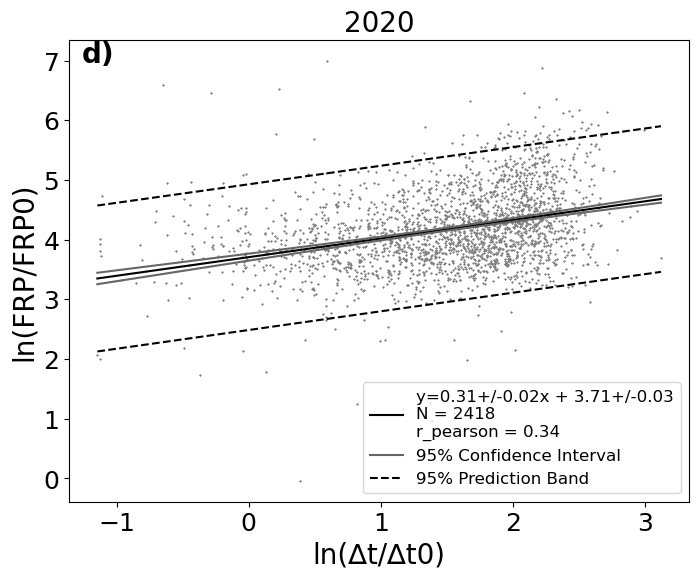

In [13]:
#Call for functions for the plots
fire_duration_x_FRP_emitted(emission_data,'frp_x_fire_duration_'+str(Year)+'_BR163_box',matrix)

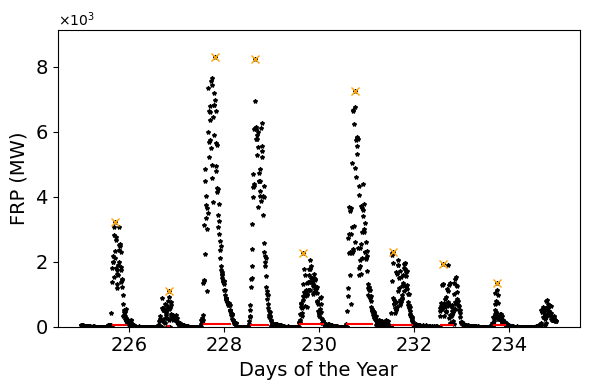

In [14]:
# Extract column names from the dataset
header = list(emission_data)

# Extract latitude values
pos2 = header.index('central_lat')
column2 = emission_data.iloc[:, pos2]
lat = np.array(column2.dropna(), dtype=pd.Series)

# Extract longitude values
pos4 = header.index('central_lon')
column4 = emission_data.iloc[:, pos4]
lon = np.array(column4.dropna(), dtype=pd.Series)

# Extract Fire Radiative Power (FRP) values
pos3 = header.index('FRP(MW)')
column3 = emission_data.iloc[:, pos3]
FRP = np.array(column3.dropna(), dtype=pd.Series)

# Extract code values (possibly representing time or location categories)
pos5 = header.index('code')
column5 = emission_data.iloc[:, pos5]
code = np.array(column5.dropna(), dtype=pd.Series)

# Define a specific 0.5° x 0.5° grid cell for analysis inside the region of interest (ROI)
index = np.where((lat == -7.75) & (lon == -55.25) & (FRP >= 0) & (code >= 225) & (code <= 235))
FRP_index = FRP[index]
code_full = code[index]

# Identify peaks in the FRP data within the selected grid cell
peaks, _ = find_peaks(FRP_index, height=75, distance=50, prominence=750)  # Threshold values for peak detection
results_partial = peak_widths(FRP_index, peaks, rel_height=0.95)  # Measure peak widths at 95% relative height

# Determine the start and end positions of detected peaks
peak_start_pos = np.int_(np.floor(results_partial[2][:]))
peak_end_pos = np.int_(np.ceil(results_partial[3][:]))

# Plot FRP distribution and detected peaks
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylabel('FRP (MW)', fontsize=14)
ax.set_xlabel('Days of the Year', fontsize=14)
ax.set_ylim(np.min(FRP_index) * 1.1, np.max(FRP_index) * 1.1)  # Adjust y-axis limits dynamically
ax.plot(code_full, FRP_index, '*', markersize=3, label='FRP', color='black')  # Plot FRP values

# Mark detected peaks on the plot
ax.plot(code_full[peaks], FRP_index[peaks], "x", color='orange')  # Mark peaks
ax.hlines(results_partial[0], code_full[peak_start_pos], code_full[peak_end_pos], color="red")  # Peak widths

# Set scientific notation for the y-axis
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Apply scientific notation outside this range
ax.yaxis.set_major_formatter(formatter)

# Adjust tick label font size
ax.tick_params(axis='both', labelsize=14)

# Ensure layout is properly adjusted
fig.tight_layout()

# Save the figure (if needed)
# plt.savefig('filename.png', dpi=200)

plt.show()